In [182]:
import time
import gc
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [183]:
pd.set_option('mode.chained_assignment', None)

In [184]:
run_params = {"Task": "train"
            , "Model": "generative task2seq"}

### Defining Methods

In [185]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [186]:
def preprocess_task(task_vector):
    # either convert to float32 or encode to categoricals
    for i, el in enumerate(task_vector):
        try:
            task_vector[i] = float(task_vector[i])
        except:
            task_vector[i] = get_key(cat_encodings[i], task_vector[i])
    return task_vector.astype('float32')

In [187]:
def group_by_notebooks(data:pd.DataFrame, vertex_col:str='vertex_l1') -> pd.DataFrame:
    notebook_cols = [[notebook_id_col, vertex_col, competition_id_col] + TASK_FEATURES]
    df = pd.DataFrame(columns=notebook_cols)
    for i, notebook_id in enumerate(data[notebook_id_col].unique()):
        notebook = data[data[notebook_id_col] == notebook_id].reset_index(drop=True)
        vertices_seq = " ".join(notebook[vertex_col])
        task_features = notebook[TASK_FEATURES].loc[0]
        competition_id = notebook[competition_id_col].unique()[0]
        row = [notebook_id, vertices_seq, competition_id] + task_features.tolist()
        df.loc[i] = row
        print('notebook #{} done'.format(notebook_id))
    return df 

In [188]:
def encode_vertices(vertices_seq, lang:dict=lang):
    # print(vertices_seq[0], type(vertices_seq[0]), vertices_seq[0].split(' '))
    try:
        encoded = np.append(np.flip(np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']])), lang['<start>'])
        # encoded = np.append(lang['<start>'], np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']]))
    except:
        print(vertices_seq[0].split(' '))
        raise Exception("Can't encode vertices")
    return encoded

In [189]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.fc = tf.keras.layers.Dense(vocab_size, activation='sigmoid')
    self.fc_vec = tf.keras.layers.Dense(dec_units, activation='sigmoid')

  def call(self, x, hidden, vec_input):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    output = tf.reshape(output, (-1, output.shape[2]))
    output = self.dropout(output)
    vec = self.fc_vec(vec_input)
    concatenated = tf.keras.layers.concatenate([vec, output], axis=1)
    x = self.fc(concatenated)
    return x, state

In [190]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [191]:
@tf.function
def train_step(inp, targ):
  loss = 0
  with tf.GradientTape() as tape:
    dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]): # for each vertex (token) from solution (sequence)
      predictions, dec_hidden = decoder(dec_input, dec_hidden, inp)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del inp, targ, gradients, variables
  gc.collect()
  return batch_loss

In [ ]:
# @tf.function
# def train_generator():
#     for epoch in range(EPOCHS):
#         gc.collect()
#         start = time.time()
#         total_loss = 0
#         for (batch, (feat, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
#             batch_loss = train_step(feat, targ)#, enc_hidden)
#             batch_perplexity = tf.exp(batch_loss)
#             total_loss += batch_loss
#             if batch % 100 == 0:
#                 print('Epoch {} Batch {} Loss {:.4f} Perplexity {:.4f}'.format(epoch + 1,
#                                                                 batch,
#                                                                 batch_loss.numpy(),
#                                                                 batch_perplexity))
#         train_losses.append(batch_loss)

#         print('Validating')
#         _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
#         val_ce.append(losses_ce)
#         val_rr.append(rouge_recalls)
#         val_rp.append(rouge_precisions)
#         if (epoch + 1) % 5 == 0:
#             print('Saving..', end='')
#             checkpoint.step.assign_add(5)
#             manager.save()
#             print('saved')
#         print('Time taken for the epoch {} sec\n'.format(time.time() - start))
#     best_epoch = np.argmin(np.mean(val_ce, axis=1))
#     print('The best epoch is {} with CE = {}, RR = {}, RP = {}'.format(best_epoch, np.mean(val_ce[best_epoch]), np.mean(val_rr[best_epoch]), np.mean(val_rp[best_epoch])))
#     plt.plot(train_losses)
#     plt.plot(np.mean(val_ce, axis=1)/10000)
#     plt.plot(np.mean(val_rr, axis=1))
#     plt.plot(np.mean(val_rp, axis=1))

In [192]:
def generate_solution(task_vector, save_outputs:bool=False):
  attention_plot = np.zeros((max_length_targ, max_length_feat))
  task_vector = preprocess_task(task_vector)
  inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
  result = ''

  dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
  dec_input = tf.expand_dims([1], 0)
  loss = 0
  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input
                                      , dec_hidden
                                      , inputs)
    # storing the attention weights to plot later on
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    predicted_vertice = get_key(lang, predicted_id)
    if (predicted_vertice != ' ')&(predicted_vertice != ''):
      # loss += loss_function(true_vector, predictions)
      # print(loss)
      result = predicted_vertice + ' ' + result #targ_lang.index_word[predicted_id] + ' '
    elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
      print('Evaluation: found start/end, ending')
      return result, task_vector#, attention_plot
    
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  if save_outputs:
    OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(OUTPUT_FILE, 'w') as f:
        last_vertice = ''
        for vertice in result.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_vertice = vertice
  return result, task_vector#, attention_plot

In [193]:
def generate_solution_with_evaluation(task_vector, true_sequence:np.array, save_outputs:bool=False):
    task_vector = preprocess_task(task_vector)
    inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
    generated_sequence_string = ''
    generated_sequence_array = []
    metrics = {}

    dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
    dec_input = tf.expand_dims([1], 0)
    loss = 0
    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input
                                          , dec_hidden
                                          , inputs)
        predicted_id = tf.argmax(predictions[0]).numpy()
        generated_sequence_array.append(predicted_id)

        predicted_vertice = get_key(lang, predicted_id)
        if (predicted_vertice != ' ')&(predicted_vertice != ''):
            loss += loss_function(true_sequence[t], predictions)
            generated_sequence_string = predicted_vertice + ' ' + generated_sequence_string
        elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
            print('Evaluation: found start/end, ending')
            return generated_sequence_string, metrics

        dec_input = tf.expand_dims([predicted_id], 0)
    ce = loss.numpy()/len(true_sequence)
    metrics.update({"Cross-Entropy":ce,
                  "Perplexity":tf.exp(ce),
                  "ROUGE-Recall":rouge_recall(true_sequence, generated_sequence_array),
                  "ROUGE-Precision": rouge_precision(true_sequence, generated_sequence_array)})
    if save_outputs:
        TODAY_NOW = datetime.now().strftime("%d-%m-%y_%H-%M-%S")
        save_generated_sequence(generated_sequence_string, output_path='./outputs/output_{}.py'.format(TODAY_NOW))
    return generated_sequence_string, metrics

In [194]:
def predict_on_test(X_test, Y_test):
    y_pred = []
    losses_ce = []
    rouge_recalls = []
    rouge_precisions = []
    print('predicting..', end=' ')
    for i, task_vector in X_test.reset_index(drop=True).iterrows():
        if i % 100 == 0:
            print('{:.1%}'.format(i/X_test.shape[0]), end=' ')
        true_vector = Y_test[i]
        result, metrics = generate_solution_with_evaluation(task_vector, true_vector)
        # print(loss.numpy())
        y_pred.append(result[:-1])
        losses_ce.append(metrics['Cross-Entropy'])
        rouge_recalls.append(metrics['ROUGE-Recall'])
        rouge_precisions.append(metrics['ROUGE-Precision'])
    print()
    y_pred = pd.DataFrame(y_pred, columns=[TARGET_COLUMN])
    print('Cross-Entropy: {}'.format(np.mean(losses_ce)))
    print('Perplexity: {}'.format(np.exp(float(np.mean(losses_ce)))))
    print('ROUGE-Recall: {}'.format(np.mean(rouge_recalls)))
    print('ROUGE-Precision: {}'.format(np.mean(rouge_precisions)))
    print('Unique answers: {}'.format(y_pred[TARGET_COLUMN].nunique()))
    return y_pred, losses_ce, rouge_recalls, rouge_precisions

In [195]:
def rouge_recall(true_string_vector:list, predicted_string_vector:list) -> float:
    true_string_vector = [el for el in true_string_vector if el != 0]
    # predicted_string_vector = [el for el in predicted_string_vector if el != 0]
    n_overlapping_words = len(set(true_string_vector).intersection(set(predicted_string_vector)))
    total_words_in_output = len(predicted_string_vector)
    return n_overlapping_words / total_words_in_output

In [196]:
def rouge_precision(true_string_vector:list, predicted_string_vector:list) -> float:
    true_string_vector = [el for el in true_string_vector if el != 0]
    n_overlapping_words = len(set(true_string_vector).intersection(set(predicted_string_vector)))
    total_words_in_reference = len(true_string_vector)
    return n_overlapping_words / total_words_in_reference

In [197]:
def save_generated_sequence(generated_sequence_string:str, output_path:str):
    # OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(output_path, 'w') as f:
        last_vertice = ''
        for vertice in generated_sequence_string.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_vertice = vertice

---

### Data Preprocessing Parameters

In [198]:
EXPORT_DATE = '2021-05-26'
REMOVE_RECURRINGS = False
TEST_SIZE = test_size = 0.25

### Reading Data

In [5]:
graph_path = '../../data/actual_graph_{}.csv'.format(EXPORT_DATE)
graph = pd.read_csv(graph_path)
graph.rename({'id':'graph_vertex_id'}, axis=1, inplace=True)
graph.columns

Index(['graph_vertex_id', 'graph_vertex', 'graph_vertex_subclass'], dtype='object')

In [6]:
COMPETITIONS_PATH = "../../data/competitions_info_cleaned_filled.csv" #./data/competitions_info_cleaned.csv
competitions_filled = pd.read_csv(COMPETITIONS_PATH)
competitions_filled.drop_duplicates(inplace=True)
competitions_filled.rename({'Description': 'description', 'Metric':'metric', 'DataType':'datatype', 'Subject':'subject', 'ProblemType':'problemtype'}
                        , axis=1, inplace=True)
competitions_filled.shape

(266, 8)

In [7]:
competitions_filled.isna().sum()

ref             0
comp_name       0
comp_type       0
description    21
metric         19
datatype       19
subject        19
problemtype    19
dtype: int64

In [8]:
competitions_filled['ref'] = competitions_filled['ref'].str.replace("'", "")

In [9]:
COMPETITIONS_PATH = "../../data/competitions_{}.csv".format(EXPORT_DATE) #./data/competitions_info_cleaned.csv
competitions = pd.read_csv(COMPETITIONS_PATH)
competitions.drop_duplicates(inplace=True)
competitions.shape

(5060, 10)

In [10]:
# competitions['ref'] = competitions['ref'].apply(lambda x: x.split(',')[0])
# competitions['ref'] = competitions['ref'].str.replace("'", "")

In [11]:
# competitions['exists_in_comp_filled'] = competitions.apply(lambda x: x['ref'] in competitions_filled['ref'].unique(), axis=1)
# competitions['exists_in_comp_filled'].value_counts()

In [12]:
# competitions_filled.merge(competitions[['id', 'ref']], on=['ref']).shape

In [13]:
competitions = competitions_filled.merge(competitions[['id', 'ref_link']], how='inner', left_on=['ref'], right_on=['ref_link'])
competitions.shape

(312, 10)

In [14]:
competitions.isna().sum()

ref             0
comp_name       0
comp_type       0
description    26
metric         23
datatype       23
subject        23
problemtype    23
id              0
ref_link        0
dtype: int64

In [15]:
NOTEBOOKS_PATH = "../../data/codeblocks_2021-04-01_concatenated_cleaned_linkedwithcompetitions_pred.csv"
# NOTEBOOKS_PATH = '../../data/markup_data_{}.csv'.format(EXPORT_DATE)
notebooks = pd.read_csv(NOTEBOOKS_PATH)
notebooks.head(5)

,kaggle_score,kaggle_comments,kaggle_upvotes,kaggle_link,kaggle_id,ref,code_block,code_block_id,comp_name,comp_type,Description,Metric,DataType,Subject,ProblemType,graph_vertex_id
0,0.77609,0,1,/claudiohfg/gallivanters-public-score-0-77609,5849655,c/gallivanters,%reload_ext autoreload\n%autoreload 2\n%matplo...,0,Gallivanters,inClass,<p>After their gaming startup PlayDoom couldn’...,categorizationaccuracy,NaN,NaN,NaN,22.0
1,0.77609,0,1,/claudiohfg/gallivanters-public-score-0-77609,5849655,c/gallivanters,import numpy as np\nimport pandas as pd\n\nfro...,1,Gallivanters,inClass,<p>After their gaming startup PlayDoom couldn’...,categorizationaccuracy,NaN,NaN,NaN,22.0
2,0.77609,0,1,/claudiohfg/gallivanters-public-score-0-77609,5849655,c/gallivanters,dim = 256\ntrain_files = []\ntest_files = []\n...,2,Gallivanters,inClass,<p>After their gaming startup PlayDoom couldn’...,categorizationaccuracy,NaN,NaN,NaN,44.0
3,0.77609,0,1,/claudiohfg/gallivanters-public-score-0-77609,5849655,c/gallivanters,with open(country_file) as json_file:\n tmp...,3,Gallivanters,inClass,<p>After their gaming startup PlayDoom couldn’...,categorizationaccuracy,NaN,NaN,NaN,8.0
4,0.77609,0,1,/claudiohfg/gallivanters-public-score-0-77609,5849655,c/gallivanters,train_set = []\nfor f in train_files:\n idx =...,4,Gallivanters,inClass,<p>After their gaming startup PlayDoom couldn’...,categorizationaccuracy,NaN,NaN,NaN,14.0


In [16]:
notebooks = notebooks.merge(graph, on='graph_vertex_id', how='left')
notebooks.shape

(77487, 18)

In [45]:
nl2ml = notebooks.merge(competitions[['ref', 'id']], left_on=['ref'], right_on=['ref'], how='inner', copy=False).rename({'id':'competition_id'}, axis=1)
print(nl2ml.shape[0])
nl2ml.drop_duplicates(inplace=True, subset=['code_block_id', 'kaggle_id'])
print(nl2ml.shape[0])

91698
77487


In [46]:
print(nl2ml['kaggle_id'].nunique(), nl2ml['ref'].nunique())

2821 266


### Vertices Preprocessing

In [48]:
nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]).value_counts()

Data_Transform          22895
EDA                     18959
Model_Train              8759
Visualization            6218
Environment              5740
Data_Extraction          4743
Other                    4423
Data_Export              2919
Model_Evaluation         1997
Hyperparam_Tuning         631
Model_Interpretation      183
Hypothesis                 20
Name: graph_vertex, dtype: int64

In [50]:
nl2ml['vertex_l1'], nl2ml['vertex_l2'] = nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]), nl2ml['graph_vertex_subclass']#.apply(lambda x: x.split(';')[0].split('.')[1])

### Missing Values

In [51]:
nl2ml.replace('-', -1, inplace=True)
print(nl2ml.isna().sum())
nl2ml.fillna(-1, inplace=True)
print(nl2ml.isna().sum())

kaggle_score                 0
kaggle_comments              0
kaggle_upvotes               0
kaggle_link                  0
kaggle_id                    0
ref                          0
code_block                   0
code_block_id                0
comp_name                    0
comp_type                    0
Description                 39
Metric                       0
DataType                 31041
Subject                  38638
ProblemType              56365
graph_vertex_id              0
graph_vertex                 0
graph_vertex_subclass        0
competition_id               0
vertex_l1                    0
vertex_l2                    0
dtype: int64
kaggle_score             0
kaggle_comments          0
kaggle_upvotes           0
kaggle_link              0
kaggle_id                0
ref                      0
code_block               0
code_block_id            0
comp_name                0
comp_type                0
Description              0
Metric                   0
DataType    

In [57]:
# TASK_FEATURES = ['comp_name', 'comp_type', 'description', 'metric', 'datatype', 'subject', 'problemtype']
TASK_FEATURES = ['comp_name', 'comp_type', 'Description', 'Metric', 'DataType', 'Subject', 'ProblemType']

In [58]:
TARGET_COLUMN = 'vertex_l2'

### Grouping chunks by notebooks

In [59]:
notebook_id_col = 'kaggle_id'
competition_id_col = 'competition_id'

### Taking Train Features

In [86]:
# nl2ml = group_by_notebooks(nl2ml, TARGET_COLUMN)
# X, y = train[TASK_FEATURES], train[TARGET_COLUMN]
prepared_data = group_by_notebooks(nl2ml, TARGET_COLUMN)
prepared_data.shape

notebook #5849655 done
notebook #6503346 done
notebook #5908144 done
notebook #12477667 done
notebook #12413028 done
notebook #5793501 done
notebook #7487496 done
notebook #2172406 done
notebook #3284527 done
notebook #3194343 done
notebook #3290387 done
notebook #3294704 done
notebook #3217707 done
notebook #3278710 done
notebook #3219666 done
notebook #3282077 done
notebook #3257973 done
notebook #3246665 done
notebook #3280506 done
notebook #3204918 done
notebook #3236580 done
notebook #3297408 done
notebook #3229249 done
notebook #3284529 done
notebook #13165378 done
notebook #13165545 done
notebook #13185381 done
notebook #8176725 done
notebook #10236817 done
notebook #10237212 done
notebook #4694897 done
notebook #4699795 done
notebook #4698397 done
notebook #4688634 done
notebook #4717547 done
notebook #4689346 done
notebook #4698989 done
notebook #4701260 done
notebook #4673536 done
notebook #4674412 done
notebook #5983656 done
notebook #5980919 done
notebook #5983674 done
note

(2821, 10)

### Converting Dtypes

In [87]:
def strip_recurrent_vertices(row):
    # sequence = row['vertex_l2'].split(' ')
    # result = []
    # if len(sequence) > 1:
    #     last_index = len(sequence) - 1
    #     i = 0
    #     while i < last_index:
    #         # print(sequence[i], sequence[i+1])
    #         if sequence[i].strip(' ') != sequence[i+1].strip(' '):
    #             # print('not equal')
    #             result.append(sequence[i])
    #         else:
    #             print('equal', sequence[i], sequence[i+1])
    #         i =+ 1
    # return " ".join(result)
    result = row['vertex_l2'].split(' ')[0] + " " + " ".join([row['vertex_l2'].split(' ')[i] for i in range(1, len(row['vertex_l2'].split(' '))) if (row['vertex_l2'].split(' ')[i-1] != row['vertex_l2'].split(' ')[i])&(row['vertex_l2'].split(' ')[i] != ' ')&(row['vertex_l2'].split(' ')[i] != '')])
    if result.split(' ')[1] == ' ':
        result.pop(1)
        return result
    else:
        return " ".join(row['vertex_l2'].split(' '))

In [88]:
if REMOVE_RECURRINGS:
    print('removing')
    prepared_data[TARGET_COLUMN] = prepared_data[TARGET_COLUMN].apply(strip_recurrent_vertices, axis=1)
# prepared_data[TARGET_COLUMN] = prepared_data[TARGET_COLUMN].apply(lambda x: x.replace(' ', ''))

In [89]:
cat_encodings = {}
print('Encoding columns: ')
for i, col in enumerate(prepared_data):
    if col[0] != TARGET_COLUMN:
        print(col[0])
        try:
            prepared_data[col] =  prepared_data[col].astype('float32')
        except:
            prepared_data[col] = pd.Categorical(prepared_data[col])
            cat_encodings.update({i:dict(enumerate(prepared_data[col].cat.categories))})
            prepared_data[col] = prepared_data[col].cat.codes

Encoding columns: 
kaggle_id
competition_id
comp_name
comp_type
Description
Metric
DataType
Subject
ProblemType


In [90]:
competitions = prepared_data[competition_id_col].iloc[:, 0].unique()
n_test_competitions = round(test_size * len(competitions))
n_val_competitions = test_size // 2
test_competitions, train_competitions = competitions[:n_test_competitions], competitions[n_test_competitions:]
test_competitions, val_competitions = test_competitions[:n_val_competitions], test_competitions[n_val_competitions:]
train = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(train_competitions)]
test = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(test_competitions)]
val = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(val_competitions)]
X_train, y_train = train[TASK_FEATURES], train[TARGET_COLUMN]
X_test, y_test = test[TASK_FEATURES], test[TARGET_COLUMN]
X_val, y_val = val[TASK_FEATURES], val[TARGET_COLUMN]
X_train.shape, X_val.shape, X_test.shape

((2498, 7), (323, 7))

In [91]:
# X_train, X_test, y_train, y_test = train_test_split(prepared_data[TASK_FEATURES], prepared_data[TARGET_COLUMN]
#                                                     , test_size=0.25, shuffle=True, random_state=123)
# X_train.shape, X_test.shape

### Target Preprocessing: Encoding Vertices

In [92]:
lang = {vertice:i+2 for i, vertice in enumerate(nl2ml[TARGET_COLUMN].unique())} #TODO: save the dict as a local file
lang.update({'<start>':1, '<end>':max(lang.values())+1})

In [95]:
# y_train.apply(encode_vertices, axis=1)

In [96]:
# X[TARGET_COLUMN] = y.apply(encode_vertices, axis=1)
# X.to_csv('../data/nl2ml_train_example.csv', index=False)

### Target Preprocessing: Padding Sequences

In [97]:
max_length_targ, max_length_feat = prepared_data[TARGET_COLUMN].squeeze().str.split(' ').str.len().max() + 2, X_train.values.shape[1]

In [98]:
Y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train.apply(encode_vertices, axis=1), maxlen=max_length_targ)
Y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test.apply(encode_vertices, axis=1), maxlen=max_length_targ)

### Model Parameters

In [100]:
n_features = len(TASK_FEATURES)

In [103]:
dataset_params = {"nrows": X_train.shape[0]
                , "nfeatures": n_features
                , "EXPORT_DATE": EXPORT_DATE
                , "REMOVE_RECURRINGS": REMOVE_RECURRINGS
                , "TEST_SIZE": TEST_SIZE}

In [104]:
# BUFFER_SIZE = len(input_tensor_train)
LR = 0.001
EPOCHS = 25
gru_units = 256
embedding_dim = 128
dropout_rate = 0.0
BATCH_SIZE = 1
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# vocab_inp_size = len(inp_lang.word_index) + 1
# vocab_tar_size = len(targ_lang.word_index) + 1

In [105]:
model_params = {"BATCH_SIZE":BATCH_SIZE
                , "LR":LR
                , "STEPS_PER_EPOCH": STEPS_PER_EPOCH
                , "embedding_dim": embedding_dim
                , "gru_units": gru_units
                , "dropout_rate": dropout_rate}

### Creating tf.Dataset

In [106]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, Y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

### Building the Model

In [108]:
decoder = Decoder(len(lang)+2, embedding_dim, gru_units, BATCH_SIZE)
sample_hidden = tf.zeros((BATCH_SIZE, gru_units))
vec_input = np.ones((1, n_features))
sample_decoder_output, state = decoder(tf.random.uniform((BATCH_SIZE, 1))
                                          , sample_hidden
                                          , vec_input
                                          )
print ('Decoder output shape: (batch_size, vocab size`) {}'.format(sample_decoder_output.shape))
decoder.summary()

Decoder output shape: (batch_size, vocab size`) (1, 74)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  9472      
_________________________________________________________________
gru (GRU)                    multiple                  296448    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  37962     
_________________________________________________________________
dense_1 (Dense)              multiple                  2048      
Total params: 345,930
Trainable params: 345,930
Non-trainable params: 0
_________________________________________________________________


In [109]:
optimizer = tf.keras.optimizers.Adam(LR)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True, reduction='none')

### Model Training or Loading Pre-Trained

In [112]:
checkpoint_dir = './checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(step=tf.Variable(1)
                                , optimizer=optimizer
                                 , decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=200)

In [113]:
# if manager.latest_checkpoint:
#     print("Restored from {}".format(manager.latest_checkpoint))

In [114]:
# decoder.compile(
#     optimizer=optimizer,
#     loss=loss_object
# )
# tf.saved_model.save(decoder, './checkpoints/model1.h5')

In [199]:
train_losses = []
val_ce = []
val_rr = []
val_rp = []

In [174]:
for epoch in range(EPOCHS):
    gc.collect()
    start = time.time()
    # enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_batch_perplexity = 0
    for (batch, (feat, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
        batch_loss = train_step(feat, targ)#, enc_hidden)
        batch_perplexity = tf.exp(batch_loss)

        total_loss += batch_loss
        total_batch_perplexity += batch_perplexity
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                            batch,
                                                            batch_loss.numpy()), end=' ')
            print('Perplexity {:.4f}'.format(batch_perplexity))
    train_losses.append(batch_loss)
    print('Validating')
    _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
    val_ce.append(losses_ce)
    val_rr.append(rouge_recalls)
    val_rp.append(rouge_precisions)
    if (epoch + 1) % 5 == 0:
        print('Saving..', end='')
        checkpoint.step.assign_add(5)
        manager.save()
        print('saved')
    print('Time taken for the epoch {} sec\n'.format(time.time() - start))
best_epoch = np.argmin(np.mean(val_ce, axis=1))
print('The best epoch is {} with CE = {}, RR = {}, RP = {}'.format(best_epoch, np.mean(val_ce[best_epoch]), np.mean(val_rr[best_epoch]), np.mean(val_rp[best_epoch])))
plt.plot(train_losses)
plt.plot(np.mean(val_ce, axis=1))
plt.plot(np.mean(val_rr, axis=1))
plt.plot(np.mean(val_rp, axis=1))

Epoch 1 Batch 0 Loss 0.1824 Perplexity 1.2000
Epoch 1 Batch 100 Loss 0.0584 Perplexity 1.0602
Epoch 1 Batch 200 Loss 0.1170 Perplexity 1.1242
Epoch 1 Batch 300 Loss 0.0729 Perplexity 1.0756
Epoch 1 Batch 400 Loss 0.0757 Perplexity 1.0787
Epoch 1 Batch 500 Loss 0.1609 Perplexity 1.1745
Epoch 1 Batch 600 Loss 0.1025 Perplexity 1.1079
Epoch 1 Batch 700 Loss 0.1728 Perplexity 1.1887
Epoch 1 Batch 800 Loss 0.0371 Perplexity 1.0378
Epoch 1 Batch 900 Loss 0.1369 Perplexity 1.1468
Epoch 1 Batch 1000 Loss 0.1390 Perplexity 1.1491
Epoch 1 Batch 1100 Loss 0.0233 Perplexity 1.0236
Epoch 1 Batch 1200 Loss 0.2114 Perplexity 1.2354
Epoch 1 Batch 1300 Loss 0.0697 Perplexity 1.0722
Epoch 1 Batch 1400 Loss 0.0098 Perplexity 1.0099
Epoch 1 Batch 1500 Loss 0.0622 Perplexity 1.0642
Epoch 1 Batch 1600 Loss 0.0663 Perplexity 1.0685
Epoch 1 Batch 1700 Loss 0.0966 Perplexity 1.1014
Epoch 1 Batch 1800 Loss 0.1228 Perplexity 1.1306
Epoch 1 Batch 1900 Loss 0.0369 Perplexity 1.0376
Epoch 1 Batch 2000 Loss 0.3660 P

KeyboardInterrupt: 

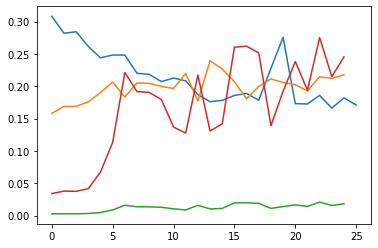

In [137]:
plt.plot(train_losses)
plt.plot(np.mean(val_ce, axis=1))
plt.plot(np.mean(val_rr, axis=1))
plt.plot(np.mean(val_rp, axis=1))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Sequence Generation

In [ ]:
# i = 0
# example_task_vector = X_test.reset_index(drop=True).loc[i]
# example_true_vector = Y_test[i]
# example_true_sequence = y_test.loc[i][0]
# print('task vector: {} \n'.format(example_task_vector.values))
# print('true sequence is: {}\n'.format(example_true_sequence))
# result, task_vector = generate_solution(example_task_vector)
# print(result, '\n')
# print('length of the result sequence is: {} \n'.format(len(result.split(' '))))

### Model Evaluation

In [ ]:
# i = 0
# example_task_vector = X_test.reset_index(drop=True).loc[i]
# example_true_vector = Y_test[i]
# example_true_sequence = y_test.loc[i][0]
# print('task vector: {} \n'.format(example_task_vector.values))
# print('true sequence is: {}\n'.format(example_true_sequence))
# result, metrics = generate_solution_with_evaluation(example_task_vector, example_true_vector, save_outputs=True)
# print('predicted sequence is: {}\n'.format(result))
# print('predicted unique sequence is: {}\n'.format(" ".join(list(set(result.split(' ')))))) #[el for i, el in enumerate(result.split(' ')) if result.split(' ')[i-1] != el])
# print('length of the result sequence is: {} \n'.format(len(result.split(' '))))
# print('Metrics:', metrics)

In [ ]:
## Predict on Train
_, _, _, _ = predict_on_test(X_train[TASK_FEATURES], Y_train)

In [ ]:
## Predict on Test
_, _, _, _ = predict_on_test(X_test[TASK_FEATURES], Y_test)

In [ ]:
# val_ce = []
# val_rr = []
# val_rp = []
# for i in range(1, EPOCHS//5 + 1):
#     checkpoint.restore('./checkpoints/ckpt-{}.index'.format(i))
#     _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
#     val_ce.append(losses_ce)
#     val_rr.append(rouge_recalls)
#     val_rp.append(rouge_precisions)

In [ ]:
# y_pred[TARGET_COLUMN].unique()

---
## To Do

In [ ]:
##TODO: To py and argparse

### To DAGsHub

In [ ]:
# ##TODO: Export to DAGsHub
# experiment_params = run_params.update(model_params)
# experiment_params = experiment_params.update(data_params)
# print(experiment_params)
# # experiment_results = {}